# Hackathon: From Raw Data to ML-Ready Dataset
## Insight-Driven EDA and End-to-End Feature Engineering on Airbnb Data Using pandas and Plotly

### What is a Hackathon?

A hackathon is a fast-paced, collaborative event where participants use data and technology to solve a real problem end-to-end.  
In this hackathon, you will work with a **real-world Airbnb dataset** and complete two interconnected goals:

- Produce a **high-quality exploratory data analysis (EDA)** using `pandas` and `plotly`, extracting meaningful insights, trends, and signals from the data.  
- Design and deliver a **clean, feature-rich, ML-ready dataset** that will serve as the foundation for a follow-up hackathon focused on building and evaluating machine learning models.

Your task is to **get the most out of the data**: uncover structure and patterns through EDA, and engineer informative features (numerical, categorical, temporal, textual (TF–IDF), and optionally image-based) to maximize the predictive power of the final dataset.

<div class="alert alert-success">
<b>About the Dataset</b>

<u>Context</u>

The data comes from <a href="https://insideairbnb.com/get-the-data/">Inside Airbnb</a>, an open project that publishes detailed, regularly updated datasets for cities around the world.  
Each city provides three main CSV files:

- <b>listings.csv</b> — property characteristics, host profiles, descriptions, amenities, etc.  
- <b>calendar.csv</b> — daily availability and pricing information for each listing.  
- <b>reviews.csv</b> — guest feedback and textual reviews.

These datasets offer a rich view of the short-term rental market, including availability patterns, pricing behavior, host attributes, and guest sentiment.  

<u>Inspiration</u>

Your ultimate objective is to create a dataset suitable for training a machine learning model that predicts whether a specific Airbnb listing will be <b>available on a given date</b>, using property attributes, review information, and host characteristics.
</div>

<div class="alert alert-info">
<b>Task</b>

Using one city of your choice from Inside Airbnb, create an end-to-end pipeline that:

1. Loads and explores the raw data (EDA).  
2. Engineers features (numerical, categorical, temporal, textual TF–IDF, etc.).  
3. Builds a unified ML-ready dataset.  

Please remember to add comments explaining your decisions. Comments help us understand your thought process and ensure accurate evaluation of your work. This assignment requires code-based solutions—**manually calculated or hard-coded results will not be accepted**. Thoughtful comments and visualizations are encouraged and will be highly valued.

- Write your solution directly in this notebook, modifying it as needed.
- Once completed, submit the notebook in **.ipynb** format via Moodle.
    
<b>Collaboration Requirement: Git & GitHub</b>

You must collaborate with your team using a **shared GitHub repository**.  
Your use of Git is part of the evaluation. We will specifically look at:

- Commit quality (clear messages, meaningful steps).  
- Balanced participation across team members.  
- Use of branches.  
- Ability to resolve merge conflicts appropriately.  
- A clean, readable project history that reflects real collaboration.

Good Git practice is **part of your grade**, not optional.
</div>
<div class="alert alert-danger">
    You are free to add as many cells as you wish as long as you leave untouched the first one.
</div>

<div class="alert alert-warning">

<b>Hints</b>

- Text columns often carry substantial predictive power, use text-vectorization methods to extract meaningful features.  
- Make sure all columns use appropriate data types (categorical, numeric, datetime, boolean). Correct dtypes help prevent subtle bugs and improve performance.  
- Feel free to enrich the dataset with any additional information you consider useful: engineered features, external data, derived temporal features, etc.  
- If the dataset is too large for your computer, use <code>.sample()</code> to work with a subset while preserving the logic of your pipeline.  
- Plotly offers a wide variety of powerful visualizations, experiment creatively, but always begin with a clear analytical question: *What insight am I trying to uncover with this plot?*

</div>




<div class="alert alert-danger">
<b>Submission Deadline:</b> Wednesday, December 3rd, 12:00

Start with a simple, working pipeline.  
Do not over-complicate your code too much. Start with a simple working solution and refine it if you have time.
</div>

<div class="alert alert-danger">
    
You may add as many cells as you want, but the **first cell must remain exactly as provided**. Do not edit, move, or delete it under any circumstances.
</div>


In [31]:
# LEAVE BLANK

### Team Information

Fill in the information below.  
All fields are **mandatory**.

- **GitHub Repository URL**: Paste the link to the team repo you will use for collaboration.
- **Team Members**: List all student names (and emails or IDs if required).

Do not modify the section title.  
Do not remove this cell.


In [32]:
# === Team Information (Mandatory) ===
# Fill in the fields below.

GITHUB_REPO = ""       # e.g. "https://github.com/myteam/airbnb-hackathon"
TEAM_MEMBERS = [
    # "Full Name 1",
    # "Full Name 2",
    # "Full Name 3",
]

GITHUB_REPO, TEAM_MEMBERS


('', [])

In [33]:
from pathlib import Path
import pandas as pd

# Build a dict of every CSV in the working directory for easy access
workspace = Path.cwd()
csv_paths = sorted(workspace.glob("*.csv"))
csv_tables = {path.stem: pd.read_csv(path) for path in csv_paths}
{name: df.shape for name, df in csv_tables.items()}

{'listings-2': (7844, 18), 'neighbourhoods': (88, 2), 'reviews-2': (405030, 2)}

In [34]:
import numpy as np

# Apply consistent cleaning rules across all loaded CSV tables
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = (
        cleaned.columns
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"[^0-9a-z]+", "_", regex=True)
        .str.strip("_")
    )
    cleaned = cleaned.loc[~cleaned.index.duplicated(keep="first")]
    cleaned = cleaned.drop_duplicates()

    empty_cols = [col for col in cleaned.columns if cleaned[col].isna().all()]
    if empty_cols:
        cleaned = cleaned.drop(columns=empty_cols)

    text_cols = cleaned.select_dtypes(include=["object", "string"]).columns
    for col in text_cols:
        cleaned[col] = cleaned[col].astype("string").str.strip()

    bool_map = {"t": True, "f": False, "true": True, "false": False, "yes": True, "no": False}
    for col in cleaned.select_dtypes(include=["string", "object"]).columns:
        lowered = cleaned[col].str.lower().dropna().unique()
        if len(lowered) > 0 and set(lowered).issubset(bool_map.keys()):
            cleaned[col] = cleaned[col].str.lower().map(bool_map)

    datetime_keywords = {"date", "time", "created", "updated", "posted"}
    for col in cleaned.columns:
        if any(keyword in col for keyword in datetime_keywords):
            cleaned[col] = pd.to_datetime(cleaned[col], errors="coerce")

    money_keywords = {"price", "fee", "amount", "cost", "revenue"}
    for col in cleaned.select_dtypes(include=["object", "string"]).columns:
        if any(keyword in col for keyword in money_keywords):
            numeric_series = (
                cleaned[col]
                .astype("string")
                .str.replace(r"[^0-9.+-]", "", regex=True)
            )
            cleaned[col] = pd.to_numeric(numeric_series, errors="coerce")

    for col in cleaned.select_dtypes(include=["object", "string"]).columns:
        numeric_series = pd.to_numeric(cleaned[col], errors="coerce")
        if numeric_series.notna().sum() >= 0.9 * len(cleaned):
            cleaned[col] = numeric_series

    return cleaned

cleaned_tables = {name: clean_dataframe(df) for name, df in csv_tables.items()}
cleaning_report = {
    name: {
        "rows_before": csv_tables[name].shape[0],
        "rows_after": cleaned_tables[name].shape[0],
        "cols_before": csv_tables[name].shape[1],
        "cols_after": cleaned_tables[name].shape[1],
    }
    for name in csv_tables
}
cleaning_report

{'listings-2': {'rows_before': 7844,
  'rows_after': 7844,
  'cols_before': 18,
  'cols_after': 18},
 'neighbourhoods': {'rows_before': 88,
  'rows_after': 88,
  'cols_before': 2,
  'cols_after': 2},
 'reviews-2': {'rows_before': 405030,
  'rows_after': 403968,
  'cols_before': 2,
  'cols_after': 2}}

In [35]:
# Compute Pearson correlations across numeric fields for each cleaned dataset
corr_matrices = {}
high_corr_pairs = {}

for name, df in cleaned_tables.items():
    numeric_df = df.select_dtypes(include=["number"]).dropna(axis=1, how="all")
    if numeric_df.shape[1] < 2:
        high_corr_pairs[name] = pd.Series(dtype=float)
        continue
    corr_matrix = numeric_df.corr(method="pearson")
    corr_matrices[name] = corr_matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_tri = corr_matrix.where(mask)
    strong_pairs = (
        upper_tri.stack()
        .rename("correlation")
        .loc[lambda series: series.abs() >= 0.7]
        .sort_values(key=np.abs, ascending=False)
    )
    high_corr_pairs[name] = strong_pairs
high_corr_pairs

{'listings-2': reviews_per_month  number_of_reviews_ltm    0.822132
 Name: correlation, dtype: float64,
 'neighbourhoods': Series([], dtype: float64),
 'reviews-2': Series([], dtype: float64)}

In [36]:
from IPython.display import display

# Present each correlation matrix for readability
for name, matrix in corr_matrices.items():
    if matrix.empty:
        print(f"{name}: no numeric columns after cleaning.")
        continue
    print(f"Correlation matrix for {name} (Pearson)")
    display(matrix)
    print()

Correlation matrix for listings-2 (Pearson)


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
id,1.000000,0.486678,-0.023433,0.012126,0.043826,-0.016146,-0.546235,0.095874,0.070746,0.117035,-0.182541
host_id,0.486678,1.000000,-0.006591,-0.001696,0.037092,-0.063676,-0.302715,0.074018,-0.143096,0.118894,-0.090197
latitude,-0.023433,-0.006591,1.000000,-0.323429,-0.047410,-0.007943,0.040264,0.030699,0.006300,-0.041294,0.030739
longitude,0.012126,-0.001696,-0.323429,1.000000,0.040129,0.021422,-0.044393,-0.028985,-0.051874,-0.005107,-0.031523
price,0.043826,0.037092,-0.047410,0.040129,1.000000,-0.031106,-0.038985,-0.056654,-0.010059,0.077078,-0.054437
minimum_nights,-0.016146,-0.063676,-0.007943,0.021422,-0.031106,1.000000,-0.075069,-0.122522,-0.058810,0.022938,-0.128313
number_of_reviews,-0.546235,-0.302715,0.040264,-0.044393,-0.038985,-0.075069,1.000000,0.478299,-0.133190,-0.093033,0.659121
reviews_per_month,0.095874,0.074018,0.030699,-0.028985,-0.056654,-0.122522,0.478299,1.000000,-0.139446,-0.024277,0.822132
calculated_host_listings_count,0.070746,-0.143096,0.006300,-0.051874,-0.010059,-0.058810,-0.133190,-0.139446,1.000000,0.033160,-0.122980
availability_365,0.117035,0.118894,-0.041294,-0.005107,0.077078,0.022938,-0.093033,-0.024277,0.033160,1.000000,-0.064885


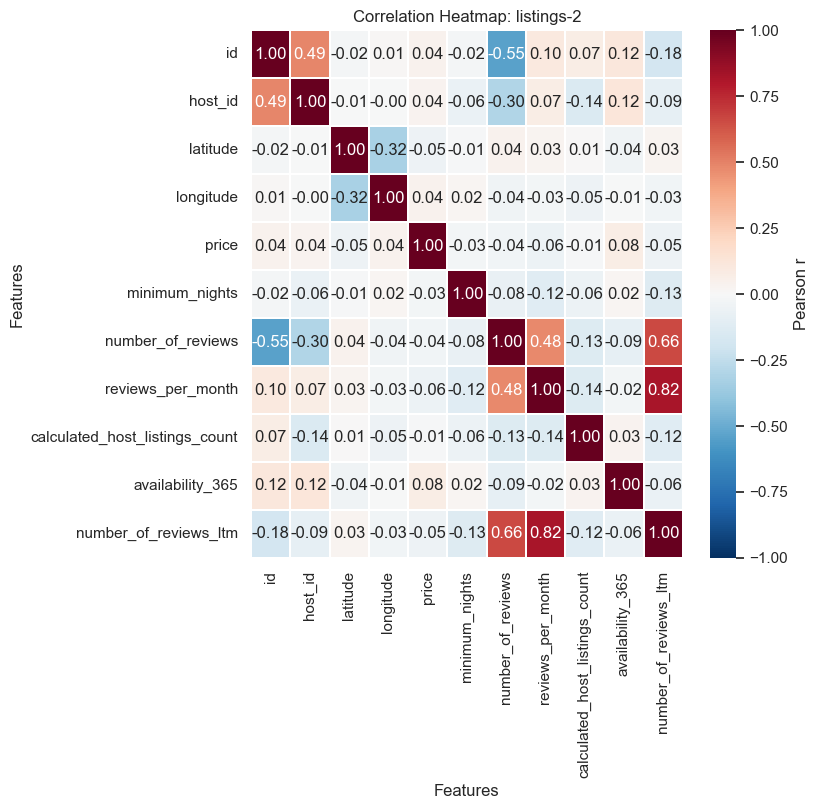

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Visualize correlations with seaborn heatmaps to avoid Plotly dependency
for name, matrix in corr_matrices.items():
    if matrix.empty or matrix.shape[0] < 2:
        continue
    fig, ax = plt.subplots(figsize=(min(12, 0.75 * matrix.shape[1]), min(10, 0.75 * matrix.shape[0])))
    sns.heatmap(
        matrix,
        ax=ax,
        cmap="RdBu_r",
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        linewidths=0.3,
        cbar_kws={"label": "Pearson r"}
    )
    ax.set_title(f"Correlation Heatmap: {name}")
    ax.set_xlabel("Features")
    ax.set_ylabel("Features")
    plt.tight_layout()
    plt.show()

In [38]:
cols_to_remove = {"reviews_per_month", "number_of_reviews_ltm"}

for name, df in cleaned_tables.items():
    removable = [col for col in cols_to_remove if col in df.columns]
    if removable:
        cleaned_tables[name] = df.drop(columns=removable)

cleaning_report = {
    name: {
        "rows_before": csv_tables[name].shape[0],
        "rows_after": cleaned_tables[name].shape[0],
        "cols_before": csv_tables[name].shape[1],
        "cols_after": cleaned_tables[name].shape[1],
    }
    for name in csv_tables
}
cleaning_report

{'listings-2': {'rows_before': 7844,
  'rows_after': 7844,
  'cols_before': 18,
  'cols_after': 16},
 'neighbourhoods': {'rows_before': 88,
  'rows_after': 88,
  'cols_before': 2,
  'cols_after': 2},
 'reviews-2': {'rows_before': 405030,
  'rows_after': 403968,
  'cols_before': 2,
  'cols_after': 2}}

Log1p skew inspection for listings-2
id: skew before=-0.56, kurt before=-1.28 | skew log1p=-1.01, kurt log1p=-0.97


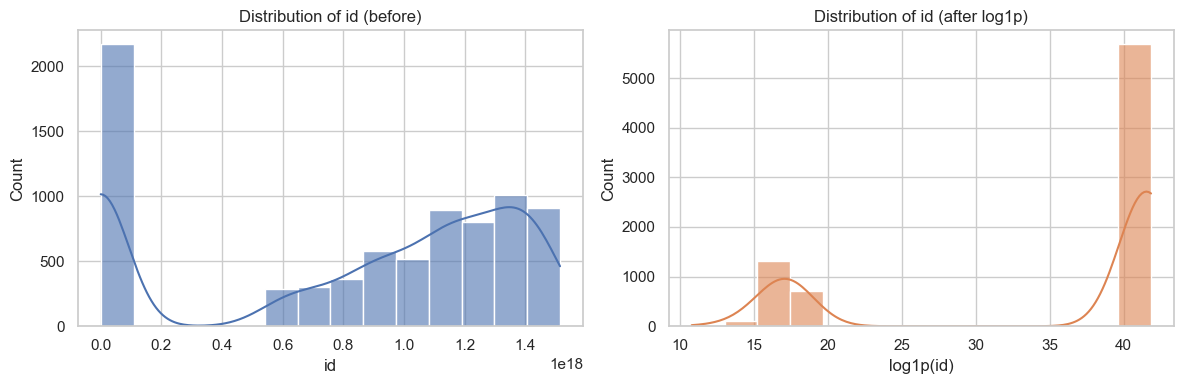

No improvement in normality detected for id.
host_id: skew before=0.28, kurt before=-1.39 | skew log1p=-1.38, kurt log1p=1.76


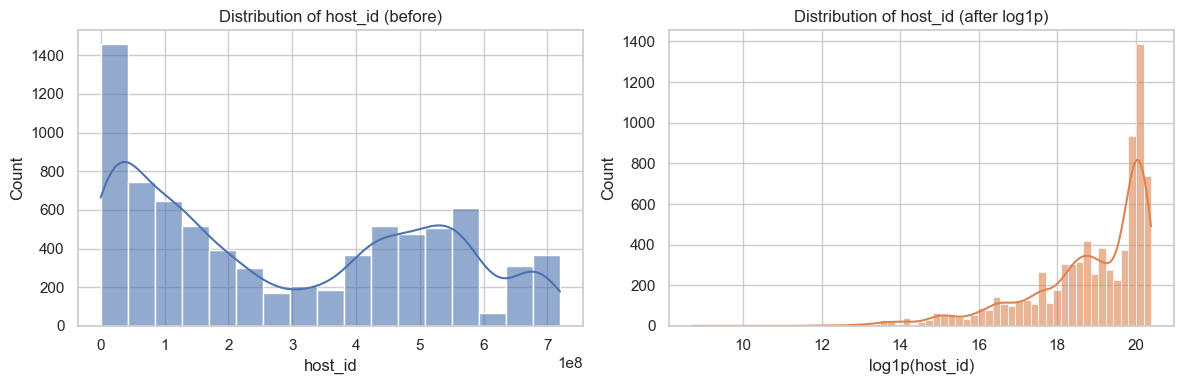

No improvement in normality detected for host_id.
latitude: skew before=-4.84, kurt before=38.53 | skew log1p=-4.85, kurt log1p=38.66


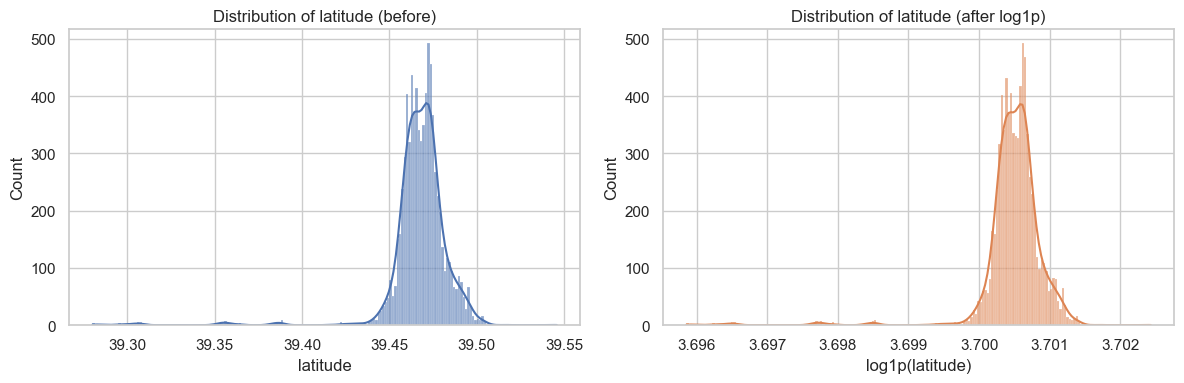

No improvement in normality detected for latitude.
price: skew before=29.44, kurt before=1328.50 | skew log1p=1.24, kurt log1p=7.77


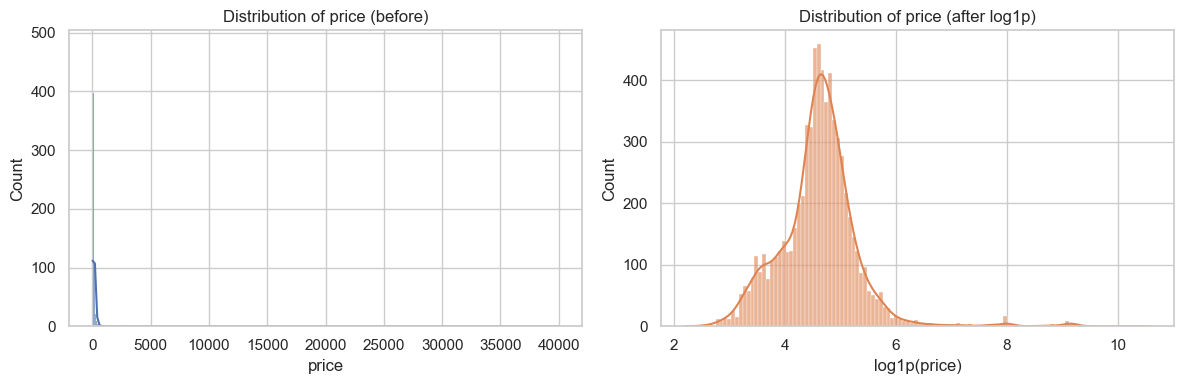

No improvement in normality detected for price.
minimum_nights: skew before=13.28, kurt before=228.09 | skew log1p=1.36, kurt log1p=1.64


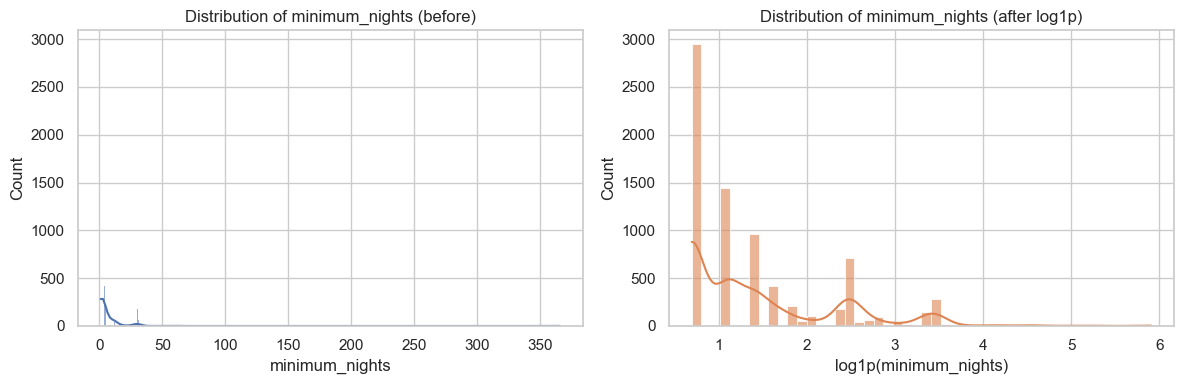

No improvement in normality detected for minimum_nights.
number_of_reviews: skew before=3.04, kurt before=11.98 | skew log1p=-0.03, kurt log1p=-1.01


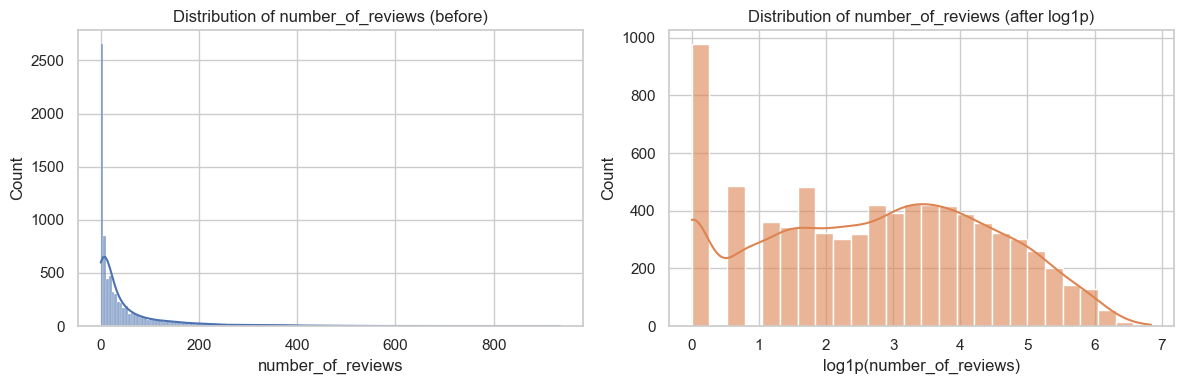

No improvement in normality detected for number_of_reviews.
calculated_host_listings_count: skew before=2.50, kurt before=5.89 | skew log1p=0.89, kurt log1p=-0.32


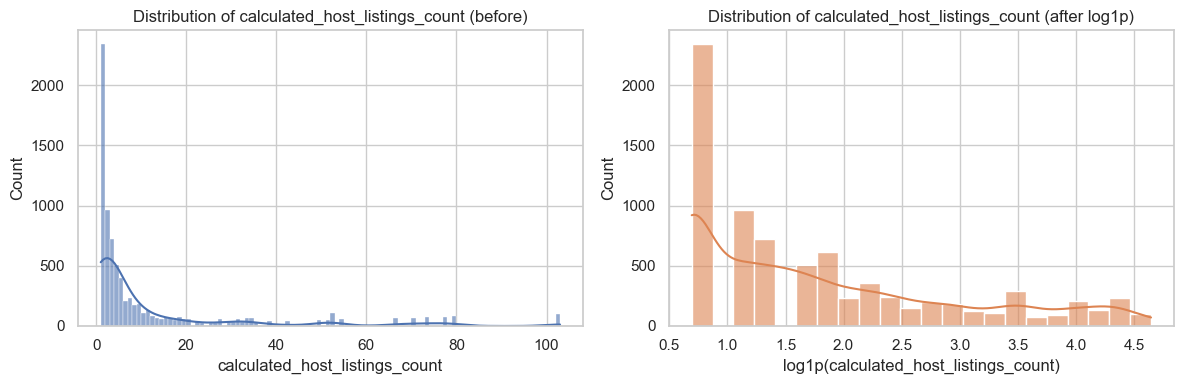

No improvement in normality detected for calculated_host_listings_count.
availability_365: skew before=-0.06, kurt before=-1.42 | skew log1p=-1.99, kurt log1p=3.36


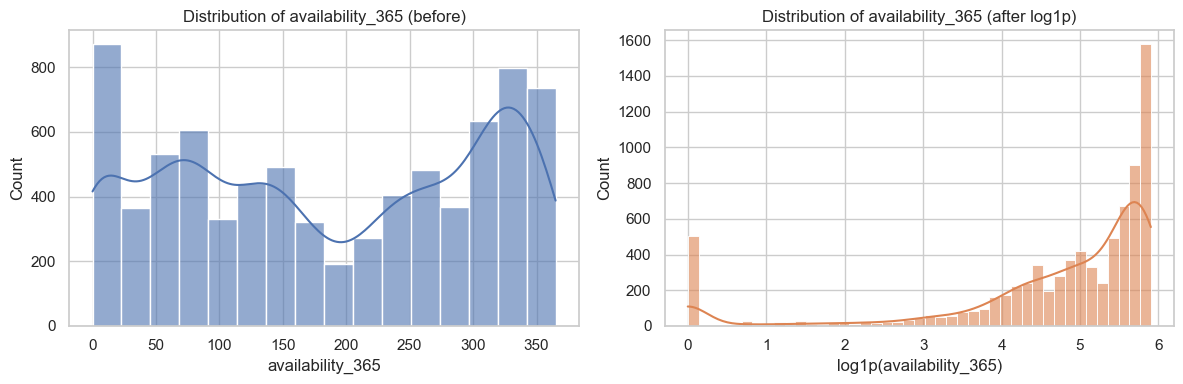

No improvement in normality detected for availability_365.

Log1p skew inspection for reviews-2
listing_id: skew before=1.00, kurt before=-0.68 | skew log1p=0.72, kurt log1p=-1.46


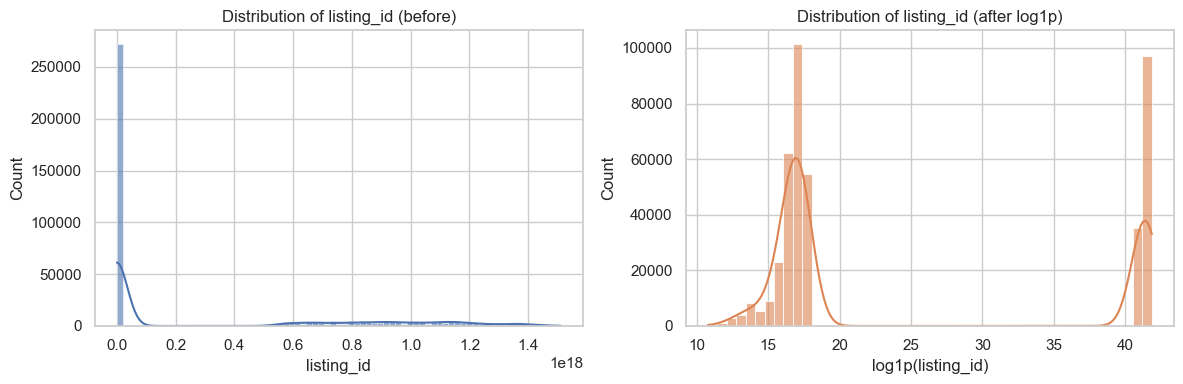

No improvement in normality detected for listing_id.



{}

In [39]:
suggested_log_transforms = {}

def approx_normal(series: pd.Series, skew_thresh: float = 0.5, kurt_thresh: float = 1.0) -> bool:
    """Heuristic check for approximate normality via skewness and kurtosis."""
    skew_val = series.skew()
    kurt_val = series.kurtosis()
    return np.isfinite(skew_val) and np.isfinite(kurt_val) and abs(skew_val) < skew_thresh and abs(kurt_val) < kurt_thresh

# Evaluate log1p transforms for skewed, non-negative numeric columns (diagnostics only)
for name, df in cleaned_tables.items():
    numeric_cols = df.select_dtypes(include=["number"]).columns
    candidate_cols = [
        col
        for col in numeric_cols
        if not df[col].dropna().empty and (df[col].dropna() >= 0).all()
    ]
    if not candidate_cols:
        continue
    print(f"Log1p skew inspection for {name}")
    better_cols = []
    for col in candidate_cols:
        col_data = df[col].dropna()
        skew_before = col_data.skew()
        kurt_before = col_data.kurtosis()
        before_normal = approx_normal(col_data)
        log_data = np.log1p(col_data)
        skew_after = log_data.skew()
        kurt_after = log_data.kurtosis()
        after_normal = approx_normal(log_data)
        print(
            f"{col}: skew before={skew_before:.2f}, kurt before={kurt_before:.2f} | skew log1p={skew_after:.2f}, kurt log1p={kurt_after:.2f}"
        )
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(col_data, kde=True, ax=axes[0], color="C0", alpha=0.6)
        axes[0].set_title(f"Distribution of {col} (before)")
        axes[0].set_xlabel(col)
        axes[0].set_ylabel("Count")
        sns.histplot(log_data, kde=True, ax=axes[1], color="C1", alpha=0.6)
        axes[1].set_title(f"Distribution of {col} (after log1p)")
        axes[1].set_xlabel(f"log1p({col})")
        axes[1].set_ylabel("Count")
        plt.tight_layout()
        plt.show()
        if after_normal and not before_normal:
            better_cols.append(col)
            print(f"log1p would improve normality for {col}.")
        else:
            print(f"No improvement in normality detected for {col}.")
    if better_cols:
        suggested_log_transforms[name] = better_cols
    print()
suggested_log_transforms

In [40]:
log1p_targets = {"price"}

applied_log_transforms = {}
for name, df in cleaned_tables.items():
    cols_applied = []
    for col in log1p_targets:
        if col in df.columns:
            cleaned_tables[name][col] = np.log1p(df[col])
            cols_applied.append(col)
    if cols_applied:
        applied_log_transforms[name] = cols_applied
applied_log_transforms

{'listings-2': ['price']}

In [41]:
encoded_tables = {}
encoding_report = {}

for name, df in cleaned_tables.items():
    table = df.copy()
    categorical_cols = table.select_dtypes(include=["object", "string", "category", "bool"]).columns
    low_cardinality_cols = [col for col in categorical_cols if table[col].nunique(dropna=True) <= 15]
    high_cardinality_cols = sorted(set(categorical_cols) - set(low_cardinality_cols))

    if low_cardinality_cols:
        table = pd.get_dummies(table, columns=low_cardinality_cols, drop_first=False, dummy_na=True)

    freq_maps = {}
    for col in high_cardinality_cols:
        freq = table[col].value_counts(normalize=True, dropna=False)
        table[col + "_freq"] = table[col].map(freq)
        freq_maps[col] = freq
    table = table.drop(columns=high_cardinality_cols)
    encoded_tables[name] = table
    encoding_report[name] = {
        "low_cardinality_one_hot": low_cardinality_cols,
        "high_cardinality_frequency": high_cardinality_cols,
        "final_shape": table.shape,
    }

encoding_report

{'listings-2': {'low_cardinality_one_hot': ['room_type'],
  'high_cardinality_frequency': ['host_name',
   'last_review',
   'license',
   'name',
   'neighbourhood',
   'neighbourhood_group'],
  'final_shape': (7844, 20)},
 'neighbourhoods': {'low_cardinality_one_hot': [],
  'high_cardinality_frequency': ['neighbourhood', 'neighbourhood_group'],
  'final_shape': (88, 2)},
 'reviews-2': {'low_cardinality_one_hot': [],
  'high_cardinality_frequency': [],
  'final_shape': (403968, 2)}}

In [ ]:
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    # Compute great-circle distance between two points (kilometers)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius_km = 6371
    return earth_radius_km * c

distance_features = {}

for name, df in cleaned_tables.items():
    table = df.copy()
    if {"latitude", "longitude"}.issubset(table.columns):
        center_lat = table["latitude"].median()
        center_lon = table["longitude"].median()
        table["distance_to_centroid_km"] = table.apply(
            lambda row: haversine_distance(
                row["latitude"], row["longitude"], center_lat, center_lon
            )
            if pd.notna(row["latitude"]) and pd.notna(row["longitude"])
            else np.nan,
            axis=1,
        )
        distance_features[name] = {
            "centroid": (center_lat, center_lon),
            "max_distance_km": table["distance_to_centroid_km"].max(),
            "mean_distance_km": table["distance_to_centroid_km"].mean(),
        }
        cleaned_tables[name] = table
    else:
        distance_features[name] = "latitude/longitude not available"

distance_features

{'listings-2': {'centroid': (np.float64(39.46851),
   np.float64(-0.37110525169342945)),
  'max_distance_km': np.float64(22.479930322495957),
  'mean_distance_km': np.float64(2.197035988151521)},
 'neighbourhoods': 'latitude/longitude not available',
 'reviews-2': 'latitude/longitude not available'}

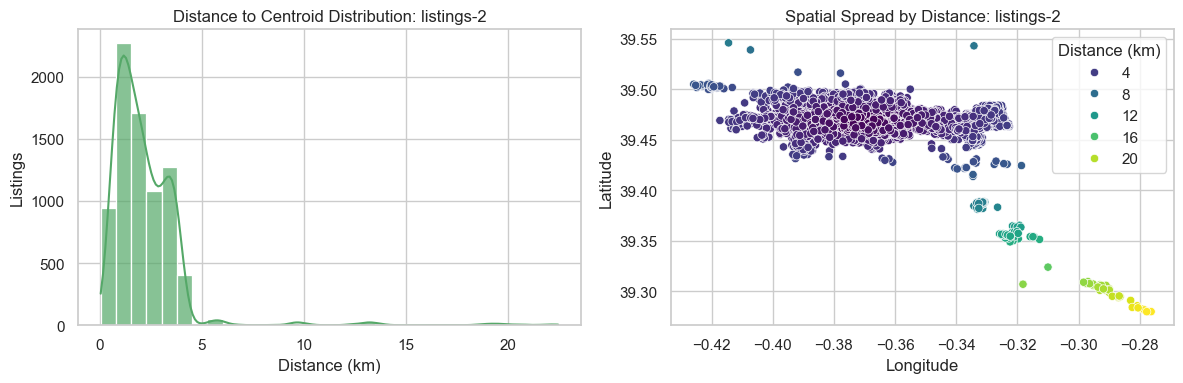

In [43]:
for name, df in cleaned_tables.items():
    if "distance_to_centroid_km" not in df.columns:
        continue
    subset = df.dropna(subset=["latitude", "longitude", "distance_to_centroid_km"])
    if subset.empty:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(subset["distance_to_centroid_km"], bins=30, kde=True, ax=axes[0], color="C2", alpha=0.7)
    axes[0].set_title(f"Distance to Centroid Distribution: {name}")
    axes[0].set_xlabel("Distance (km)")
    axes[0].set_ylabel("Listings")
    sns.scatterplot(
        data=subset,
        x="longitude",
        y="latitude",
        hue="distance_to_centroid_km",
        palette="viridis",
        ax=axes[1]
    )
    axes[1].set_title(f"Spatial Spread by Distance: {name}")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].legend(title="Distance (km)", loc="best")
    plt.tight_layout()
    plt.show()

In [44]:
pip install geopandas contextily pyproj shapely rtree

Note: you may need to restart the kernel to use updated packages.


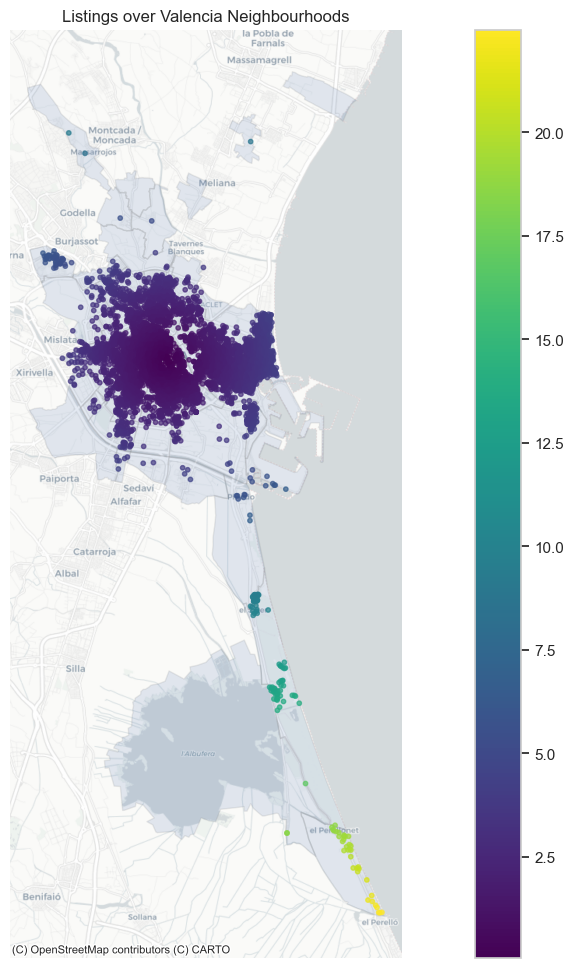

In [49]:
import geopandas as gpd

try:
    import contextily as ctx
    HAS_CONTEXTILY = True
except ImportError:
    HAS_CONTEXTILY = False
    print("contextily is not installed. Run 'pip install contextily' for basemap support; continuing without it.")

neighbourhoods_path = workspace / "neighbourhoods.geojson"
if not neighbourhoods_path.exists():
    raise FileNotFoundError("neighbourhoods.geojson is required for the Valencia overlay but was not found.")

neighbourhoods = gpd.read_file(neighbourhoods_path)
neighbourhoods_3857 = neighbourhoods.to_crs(epsg=3857)

for name, df in cleaned_tables.items():
    if not {"latitude", "longitude"}.issubset(df.columns):
        continue
    points = df.dropna(subset=["latitude", "longitude"])
    if points.empty:
        continue
    gdf = gpd.GeoDataFrame(
        points.copy(),
        geometry=gpd.points_from_xy(points["longitude"], points["latitude"]),
        crs="EPSG:4326",
    ).to_crs(epsg=3857)
    ax = neighbourhoods_3857.plot(figsize=(15, 10), alpha=0.15, edgecolor="gray")
    plot_kwargs = {
        "ax": ax,
        "markersize": 10,
        "alpha": 0.7,
    }
    if "distance_to_centroid_km" in gdf.columns:
        plot_kwargs.update({
            "column": "distance_to_centroid_km",
            "cmap": "viridis",
            "legend": True,
        })
    else:
        plot_kwargs["color"] = "C0"
    gdf.plot(**plot_kwargs)
    if HAS_CONTEXTILY:
        try:
            basemap_provider = ctx.providers.Stamen.TonerLite
        except AttributeError:
            basemap_provider = ctx.providers.CartoDB.Positron
        ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=basemap_provider)
        title_suffix = "basemap"
    else:
        title_suffix = "no basemap (install contextily)"
    ax.set_title(f"Listings over Valencia Neighbourhoods")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()